## Import Packages

In [5]:
# API Requests for data
import requests

# Data Manipulation and Analysis
import pandas as pd
from pprint import pprint 
import json
from io import StringIO
import numpy as np

# Database Connection
from sqlalchemy import create_engine

# SQL Querying
from sqlalchemy import inspect, text

#  Plotting and Visualization
from plotnine import *
from plotnine.scales import scale_x_date
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
from plotnine.exceptions import PlotnineWarning


# Regressions and Statistics
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# File and System Operations
import os
import sys

## Other Setup

In [6]:
pd.set_option('display.max_columns', None) # Display all columns in any given DataFrame

### Import Custom Packages

In [7]:
# Change the wd
sys.path.insert(0,'../src/')

#Import the packages
from macro_utils import sql_queries as sqlq
from macro_utils import functions as macro

## Data Setup and Import

### Load in the Data from Penn World Tables

In [8]:
# Read in the PWT Data
cpi=pd.read_excel('../data/cpi_by_item.xlsx')



## Data Cleaning

### Change the Column Names

In [9]:
# convert all columns to lowercase with underscore format
cpi.columns = cpi.columns.str.lower().str.replace(' ', '_')

# convert all the x-month_%_change columns to x_month_pct_change for x in 1,3,6,12
for x in [1, 3, 6, 12]:
    cpi.columns = cpi.columns.str.replace(f'{x}-month_%_change', f'{x}_month_pct_change')

# create an inverse mapping of these column names back to the original, names
inverse_col_map = {v: k for k, v in zip(cpi.columns, cpi.columns.str.replace('_', ' ').str.title())}

cpi.head()


,series_id,year,period,label,value,1_month_pct_change,3_month_pct_change,6_month_pct_change,12_month_pct_change
0,CUUR0000SA0,2015,M01,2015 Jan,233.707,-0.5,-1.6,-1.9,-0.1
1,CUUR0000SA0,2015,M02,2015 Feb,234.722,0.4,-0.6,-1.3,0.0
2,CUUR0000SA0,2015,M03,2015 Mar,236.119,0.6,0.6,-0.8,-0.1
3,CUUR0000SA0,2015,M04,2015 Apr,236.599,0.2,1.2,-0.4,-0.2
4,CUUR0000SA0,2015,M05,2015 May,237.805,0.5,1.3,0.7,0.0


### Add new Columns

In [10]:
# Add A column for the Actual Name of the Series
# Manual mapping of series_id to full names
series_name_map = {
    'CUUR0000SA0': 'U.S. city average All items Not Seasonally Adjusted',
    'CUUS0000SAA': 'U.S. city average Apparel Not Seasonally Adjusted',
    'CCUUS0000SETA02': 'U.S. city average Used cars and trucks Not Seasonally Adjusted',
    'CUUR0000SERE01': 'U.S. city average Toys Not Seasonally Adjusted',
    'CUUR0000SA0L1E' : 'U.S. city average All items Less Food and Energy Not Seasonally Adjusted',
    'CUURN000SAH3': 'U.S. city average Housing Not Seasonally Adjusted'

}

# Map full name
cpi['series_full_name'] = cpi['series_id'].map(series_name_map)

# Extract short name (last part before "Not Seasonally Adjusted")
cpi['series_short_name'] = cpi['series_full_name'].str.extract(r'U\.S\. city average (.*?) Not Seasonally Adjusted')

# Add a column for data
# Only keep rows where period matches 'M01' to 'M12' (the others are seasons)
cpi = cpi[cpi['period'].str.match(r'^M(0[1-9]|1[0-2])$')].copy()

# Combine year and period to create a YYYY-MM string, then convert to datetime (end of month)
cpi['date'] = pd.to_datetime(
    cpi['year'].astype(str) + '-' + cpi['period'].str.replace('M', ''), 
    format='%Y-%m'
) + pd.offsets.MonthEnd(0)


# Move columns for readability
start_cols = ['series_id', 'series_short_name', 'date', 'series_full_name', 'value']
cpi = cpi[start_cols + [col for col in cpi.columns if col not in start_cols]]

In [11]:
# display unlimited rows
pd.set_option('display.max_rows', None)
# set back to default
pd.reset_option('display.max_rows')

In [12]:
#get all the unique valyes in series_id
series_ids = cpi['series_id'].unique()
series_ids

array(['CUUR0000SA0', 'CUUR0000SA0L1E', 'CUUR0000SERE01', 'CUURN000SAH3'],
      dtype=object)

In [13]:
cpi['series_short_name'].unique()

array(['All items', 'All items Less Food and Energy', 'Toys', 'Housing'],
      dtype=object)

## Plot the Differerent Inflation Series


### Setup

#### Y series Labels and Mappings

In [26]:
long_df = cpi

# create a mapping for colors and linetypes
# map each series id to a colour in color_map using a yellow to red gradient
# Get unique series_ids to map
series_ids = long_df['series_id'].dropna().unique()

# Use matplotlib's colormap to generate a yellow-to-red spectrum
cmap = plt.get_cmap('autumn')  # yellow to red
colors = [mcolors.to_hex(cmap(i / (len(series_ids) - 1))) for i in range(len(series_ids))]

# Map each series_id to a color
color_map = dict(zip(series_ids, colors))

# Map each series_id to its series_short_name for labels
series_name_map = dict(zip(series_ids, long_df['series_short_name'].dropna().unique()))
# Edit the values in series nam map to have a line break after the least of 14 characters in or
# the beginning of the word containing the 14th character
for key, value in series_name_map.items():
    if len(value) > 14:
        # Find the index of the 14th character
        index = 14
        # Find the next space after the 14th character
        while index < len(value) and value[index] != ' ':
            index += 1
        # Insert a line break at that position
        series_name_map[key] = value[:index] + '\n' + value[index:].strip()



In [27]:
series_name_map

{'CUUR0000SA0': 'All items',
 'CUUR0000SA0L1E': 'All items Less\nFood and Energy',
 'CUUR0000SERE01': 'Toys',
 'CUURN000SAH3': 'Housing'}

### X Series Labels

In [23]:
# 1. Select relevant columns and remove duplicates
label_df = long_df[['date', 'label']].drop_duplicates().sort_values('date')

# 2. Choose every 2nd row (adjust the step size as needed)
label_df_filtered = label_df.iloc[::6, :]

# 3. Extract breaks and labels
yq_breaks = label_df_filtered['date'].tolist()
yq_labels = label_df_filtered['label'].tolist()


In [24]:
series_name_map

{'CUUR0000SA0': 'All items',
 'CUUR0000SA0L1E': 'All items Less Food and Energy',
 'CUUR0000SERE01': 'Toys',
 'CUURN000SAH3': 'Housing'}

### Plot

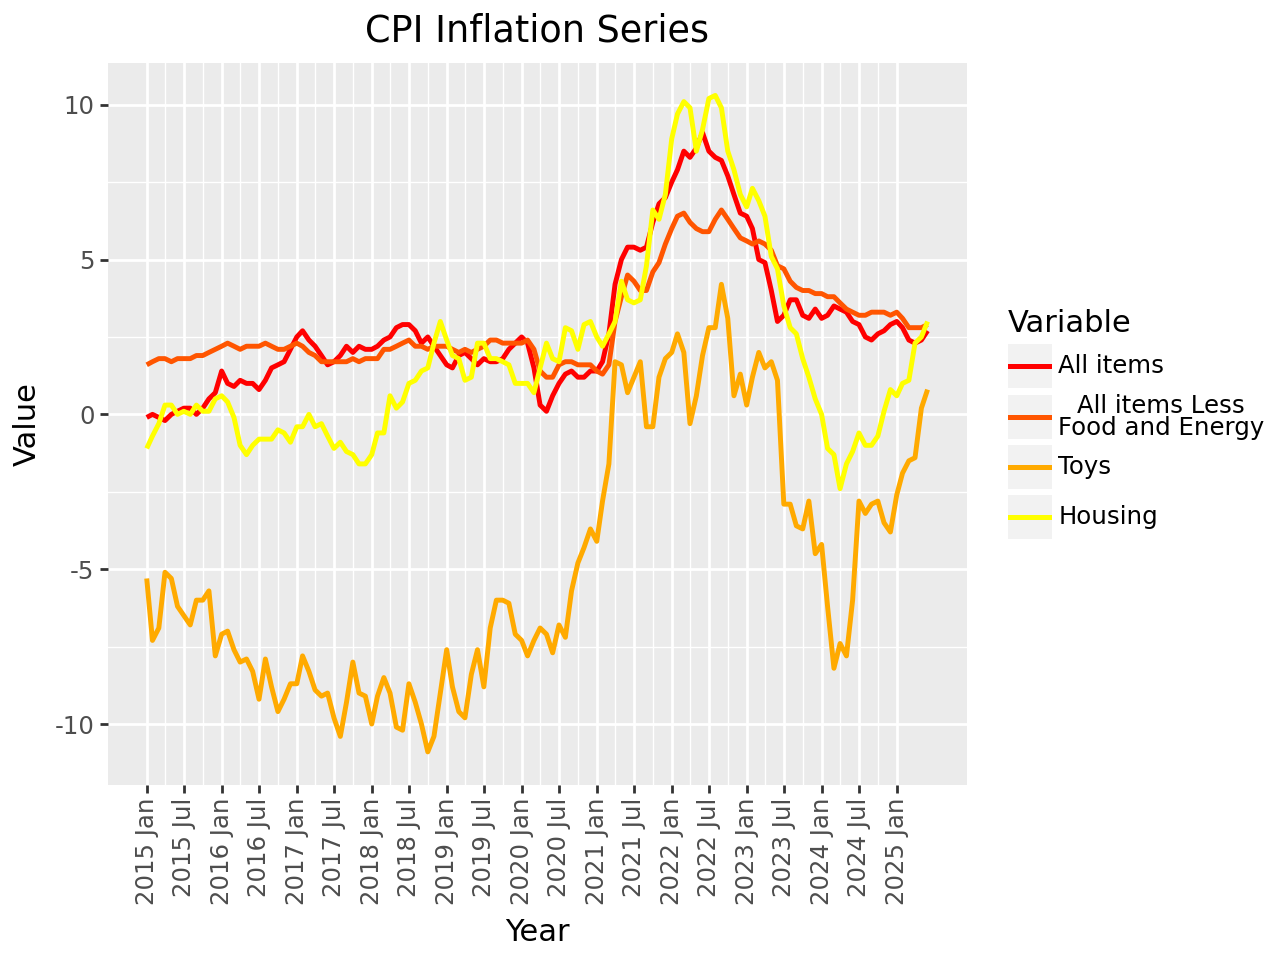

In [28]:
# Actually PLot the plot
plot = (
    ggplot(long_df, aes(x='date', y='12_month_pct_change', color='series_id')) +
    geom_line(size=1) +
    scale_color_manual(values=color_map, labels = series_name_map) +
    labs(
        title=f'CPI Inflation Series',
        x='Year',
        y='Value',
        color='Variable',
        linetype='Variable'
    ) +
    # Custom x-axis ticks
    scale_x_date(breaks = yq_breaks, labels = yq_labels) +
    theme(
        axis_text_x=element_text(rotation=90, ha='center'),
        legend_position='right'
    ) +
    guides(linetype=None)  # Remove linetype legend if desired
)

display(plot)